In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [5]:
variable_info = [
    # Firm Variables
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for sector <dim:i> goods by sector <dim:j>",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demanded by sector <dim:i>",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha",
        dims="i",
        description="Share of capital in sector <dim:i>'s production process",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    # Household Parameters
    Parameter(
        name="gamma",
        dims="i",
        description="Household utility weight on consumption of sector <dim:i> goods",
    ),
    # Exogenous variables
    Parameter(name="L_s", description="Exogenous household labor supply"),
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_Ag_bar",
        latex_name=r"\bar{P}_{Ag}",
        description="Exogenous agricultural price level",
    ),
]

equations = [
    # # Firm Equations
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC[None] * P_VC[None] = (P[:, None] * X).sum(axis=0).ravel()",
    ),
    Equation("Sector <dim:i> demand for sector <dim:j> intermediate input", "X = psi_X * VC[None]"),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor-capital",
        "VA = A * (alpha * K_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for capital", "K_d = VA / A * (alpha * P_VA * A / r) ** phi_VA"
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha) * A * P_VA / w) ** phi_VA",
    ),
    # # Household Equations
    Equation("Household income", "income = w * L_s + r * K_s"),
    Equation("Household utility", "U = (C**gamma).prod()"),
    Equation("Household demand for good <dim:i>", "C = gamma * income / P"),
    # # Market clearning conditions
    Equation("Labor market clearing", "L_s = L_d.sum() + resid"),
    Equation("Capital market clearing", "K_s = K_d.sum()"),
    Equation("Sector <dim:i> goods market clearing", "Y = C + X.sum(axis=1)"),
    Equation("Numeraire", "P[0] = P_Ag_bar"),
]

In [6]:
sectors = ["Ag", "Ind", "Serv"]

n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
)

In [7]:
mod.summary()

<IPython.core.display.Latex object>

In [8]:
data = np.array(
    [
        [0, 0, 0, 1000, 2000, 4000],
        [0, 0, 0, 500, 2000, 500],
        [7000, 3000, 0, 0, 0, 0],
        [0, 0, 2000, 1000, 1000, 1000],
        [0, 0, 2500, 2000, 3500, 3000],
        [0, 0, 5500, 500, 2500, 1000],
    ]
)

cols = ["L_d", "K_d", "Men", "Ag", "Ind", "Serv"]
df = pd.DataFrame(data, columns=cols, index=cols, dtype="float64")

In [9]:
df

,L_d,K_d,Men,Ag,Ind,Serv
L_d,0.0,0.0,0.0,1000.0,2000.0,4000.0
K_d,0.0,0.0,0.0,500.0,2000.0,500.0
Men,7000.0,3000.0,0.0,0.0,0.0,0.0
Ag,0.0,0.0,2000.0,1000.0,1000.0,1000.0
Ind,0.0,0.0,2500.0,2000.0,3500.0,3000.0
Serv,0.0,0.0,5500.0,500.0,2500.0,1000.0


In [10]:
data = {
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "phi_VA": np.full(n_sectors, 3.0),
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "r": 1.0,
    "w": 1.0,
    "P_Ag_bar": 1.0,
}

In [11]:
def calibrate_model(L_d, K_d, Y, X, P, P_VA, P_VC, r, w, phi_VA, P_Ag_bar):
    calib_dict = {
        "L_d": L_d,
        "K_d": K_d,
        "Y": Y,
        "X": X,
        "P": P,
        "r": r,
        "w": w,
        "P_VA": P_VA,
        "P_VC": P_VC,
        "phi_VA": phi_VA,
        "P_Ag_bar": P_Ag_bar,
    }

    rho_VA = (phi_VA - 1) / phi_VA

    # Numeraire
    resid = 0.0

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    income = w * L_s + r * K_s
    C = Y - X.sum(axis=1)
    gamma = C / income * P
    U = (C**gamma).prod()

    # Firm calibration
    VA = (w * L_d + r * K_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha = r * K_d ** (1 / phi_VA) / ((r * K_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    A = VA * (alpha * K_d**rho_VA + (1 - alpha) * L_d**rho_VA) ** (-1 / rho_VA)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    calib_dict["VA"] = VA
    calib_dict["VC"] = VC
    calib_dict["psi_VC"] = psi_VC
    calib_dict["psi_VA"] = psi_VA
    calib_dict["psi_X"] = psi_X
    calib_dict["alpha"] = alpha
    calib_dict["A"] = A

    calib_dict["income"] = income
    calib_dict["C"] = C
    calib_dict["U"] = U
    calib_dict["gamma"] = gamma

    calib_dict["K_s"] = K_s
    calib_dict["L_s"] = L_s
    calib_dict["resid"] = resid
    calib_dict["w"] = w

    return calib_dict

In [13]:
calibrated_data = calibrate_model(**data)
var_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.parameter_names]]
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [14]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array

labor_increase = calibrated_data.copy()
labor_increase["L_s"] = 10_000
_, theta_labor_increase = variable_dict_to_flat_array(labor_increase, mod.variables, mod.parameters)

In [15]:
n_steps = 10_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_labor_increase, n_steps=n_steps
)

In [16]:
new_data = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]
mod.check_for_equilibrium(new_data)

Equilibrium not found. Total squared error: 0.000581


In [21]:
flat_array_to_variable_dict(
    np.r_[res.x, theta_labor_increase], mod.variables + mod.parameters, mod.coords
)

{'Y': array([ 6449.56371535, 14186.0383614 , 12340.32884554]),
 'VA': array([1934.86911461, 5158.55940415, 5845.41892684]),
 'VC': array([4514.69460075, 9027.47895725, 6494.90991871]),
 'X': array([[1289.91274307, 1289.63985104, 1298.98198374],
        [2579.82548614, 4513.73947863, 3896.94595122],
        [ 644.95637154, 3224.09962759, 1298.98198374]]),
 'L_d': array([1462.28677767, 3126.19371695, 5411.51950337]),
 'K_d': array([ 483.79753326, 2068.60219966,  447.60026708]),
 'U': array(4772.7521187),
 'C': array([2571.0291375 , 3195.52744541, 7172.29086268]),
 'income': array(12855.14568752),
 'r': array(1.09741197),
 'w': array(0.95629098),
 'P_VA': array([0.99712008, 1.01959855, 0.96933842]),
 'P_VC': array([1.00123425, 0.99777984, 1.00058517]),
 'P': array([1.        , 1.00571392, 0.98578408]),
 'resid': array(2.01490501e-06),
 'psi_VA': array([0.3       , 0.36363636, 0.47368421]),
 'psi_VC': array([0.7       , 0.63636364, 0.52631579]),
 'psi_X': array([[0.28571429, 0.14285714, 0.

In [24]:
from cge_modeling.base.utilities import flat_array_to_variable_dict

res = mod._solve_with_root(calibrated_data, theta_labor_increase, method="hybr", use_jac=False)
res_d = flat_array_to_variable_dict(
    np.r_[res.x, theta_labor_increase], mod.variables + mod.parameters, mod.coords
)
mod.check_for_equilibrium(res_d)
res

Equilibrium found! Total squared error: 0.000000


 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00 -1.924e-12 ...  0.000e+00  0.000e+00]
       x: [ 6.450e+03  1.419e+04 ...  9.858e-01  2.015e-06]
    nfev: 51
    fjac: [[-6.224e-01  1.828e-12 ... -3.744e-13  4.412e-21]
           [ 7.171e-04 -6.271e-01 ... -9.302e-13  9.210e-21]
           ...
           [-2.421e-01 -2.496e-01 ...  2.200e-01 -2.166e-03]
           [ 7.412e-04  5.465e-04 ... -4.666e-04 -1.000e+00]]
       r: [-1.607e+00 -1.837e-03 ... -2.656e-01  5.628e-04]
     qtf: [-3.349e-06 -6.770e-06 ...  1.059e-05 -1.777e-08]

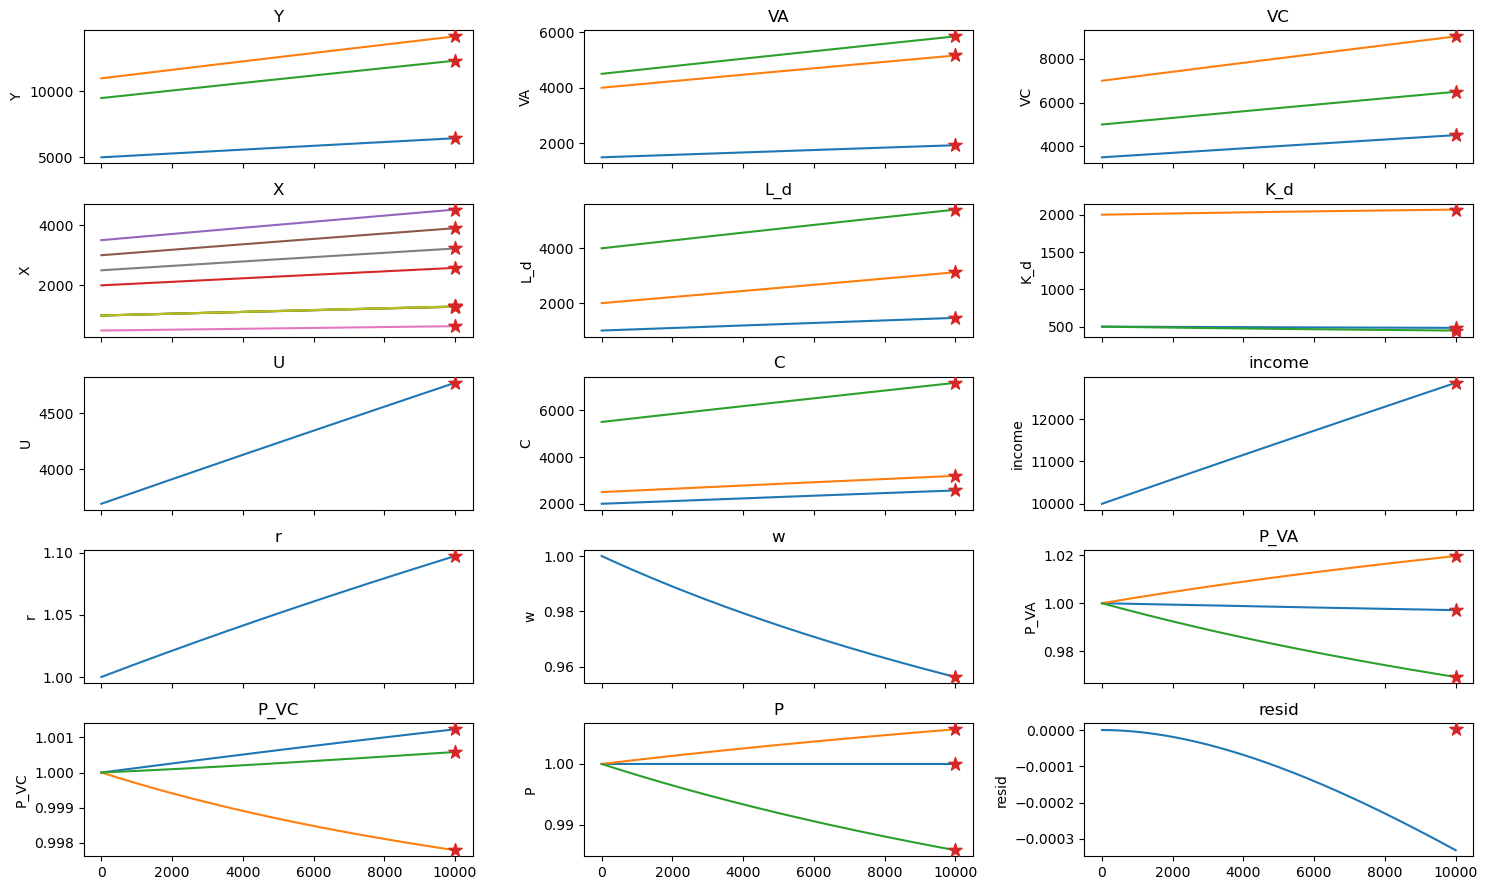

In [27]:
fig, ax = plt.subplots(5, 3, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()